# Biweekly Report 
## Pragna
## Mandadi
## Comparative Analysis on Visualization of image after one block of ResNet, Residual Attention Network and Squeeze and Excitation Network

In this biweekly report I wanted to explore how the Attention and squeeze and excitation effect the image compared to a regular ResNet. I have used Tenserflow Keras to implement all the models. Through this report I would like to know how the Attention and Squeeze and Excitation techniques help improve the accuracy of image classification. The various papers I referenced to implement and write this report are below:
https://arxiv.org/pdf/1709.01507.pdf
https://arxiv.org/pdf/1704.06904.pdf

In [121]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

In [ ]:
!pip install keras

In [ ]:
!pip install --upgrade tensorflow

I wanted to explore the Cifar-10 dataset and get familiarized with it for this report. Cifar-10 has 50000 images for training and 10000 images to test with the size 32x32x3.

In [122]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

I chose ResNet50 from keras application as the base model i.e to see how the image transforms with one ResNet block without the Attention and Squeeze and Excitation techniques. 

In [123]:
model = ResNet50()

I have checked the model summary to determine at exactly which layer one block of Resnet completes. I have determined that exactly at the 17th layer the addition of the previous convolution block is done. As the model comes already with pre-trained weights in keras, I directly cropped ResNet Network and created model that gives an output after 17 layers.

In [124]:
model = Model(inputs=model.inputs, outputs=model.layers[17].output)

In [125]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

The Keras ResNet takes the input shape as 224x224x3, therefore I'm doing a smart resize of the first picture in the cifar-10 training dataset which is a FROG.

In [126]:
size = (224,224)
resized_xtrain=tf.keras.preprocessing.image.smart_resize(x_train[0], size, interpolation='bilinear')

In [127]:
resized_xtrain.shape

(224, 224, 3)

In [128]:
resized_xtrain = expand_dims(resized_xtrain, axis=0)

In [129]:
resized_xtrain = preprocess_input(resized_xtrain)

The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features. As there are 256 feature maps, I plotted 256 two dimensional images in the red, green, blue channels.

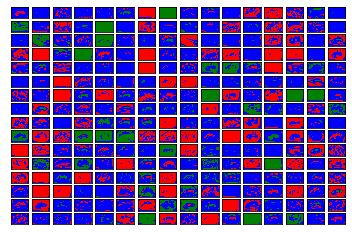

In [133]:
from matplotlib.colors import ListedColormap
feature_maps = model.predict(resized_xtrain)
cMap = ListedColormap(['green', 'blue','red'])
square = 16
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap=cMap, aspect='auto')
        ix += 1
# show the figure
pyplot.show()

To look feature maps more clearly I have also plotted them in gray scale which could be helpful for the comparision later

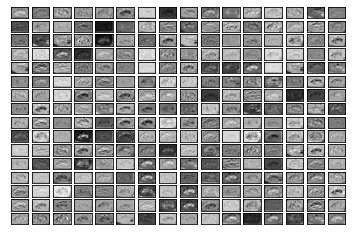

In [134]:
from matplotlib.colors import ListedColormap
feature_maps = model.predict(resized_xtrain)
cMap = ListedColormap(['green', 'blue','red'])
square = 16
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray', aspect='auto')
        ix += 1
# show the figure
pyplot.show()

In [78]:
!pip install albumentations

     |████████████████████████████████| 98 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 13.0 MB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 42.6 MB 14.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 54.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 37.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 35.3 MB/s eta 0:00:01
     |████████████████████████████████| 171 kB 20.1 MB/s eta 0:00:01


Here I started implementation of the Squeeze and Excitation Network

In [79]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from keras.layers import Activation, Reshape, Permute, multiply, MaxPooling2D, AveragePooling2D
import albumentations as albu
from albumentations import (HorizontalFlip, ShiftScaleRotate, GridDistortion)
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Loaded the cifar-10 dataset again

In [80]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

I splitted the training data into train and validation sets with the validation size as 0.25

In [82]:
from tensorflow.keras.utils import to_categorical
train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.25, random_state = 2019)

Below I have implemented a CNN with squeeze and excitation block with sigmoid activation function. I have referenced the git hub repo: https://github.com/RayXie29/SENet_Keras/blob/master/Cifar10_Keras_example.ipynb. 

In [92]:
def _swish(x):
  return K.sigmoid(x)*x

def _conv_bn_act(filters = 32, kernel_size = (3,3), strides = 1, activation = "relu"):

  def f(input_x):

    x = Conv2D(filters = filters, kernel_size = kernel_size, strides = (strides, strides), kernel_initializer="he_normal")(input_x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    return x

  return f

def _fc_bn_act(units, activation = "relu"):

  def f(input_x):

    x = Dense(units = units, kernel_initializer="he_normal")(input_x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x
  return f

def SEBlock(se_ratio = 16, activation = "relu", data_format = 'channels_last', ki = "he_normal"):
    '''
    se_ratio : ratio for reduce the filter number of first Dense layer(fc layer) in block
    activation : activation function that of first dense layer
    data_format : channel axis is at the first of dimension or the last
    ki : kernel initializer
    '''

    def f(input_x):

        channel_axis = -1 if data_format == 'channels_last' else 1
        input_channels = input_x.shape[channel_axis]

        reduced_channels = input_channels // se_ratio

        #Squeeze operation
        x = GlobalAveragePooling2D()(input_x)
        x = Reshape(1,1,input_channels)(x) if data_format == 'channels_first' else x
        x = Dense(reduced_channels, kernel_initializer= ki)(x)
        x = Activation(activation)(x)
        #Excitation operation
        x = Dense(input_channels, kernel_initializer=ki, activation='sigmoid')(x)
        x = Permute(dims=(3,1,2))(x) if data_format == 'channels_first' else x
        x = multiply([input_x, x])

        return x

    return f


def CNN(input_shape = (32,32,3), output_units = 10, activation = _swish, SE_flag = False, data_format = 'channels_last'):

  input_layer = keras.layers.Input(shape = input_shape)

  x = _conv_bn_act(filters=32, activation = activation)(input_layer)
  x = SEBlock(se_ratio=1, activation = activation, data_format=data_format)(x) if SE_flag == True else x
  x = _conv_bn_act(filters=32, activation = activation)(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = _conv_bn_act(filters=64, activation = activation)(x)
  x = SEBlock(se_ratio=1, activation = activation, data_format=data_format)(x) if SE_flag == True else x
  x = _conv_bn_act(filters=64, activation = activation)(x)
  x = Dropout(0.25)(x)

  #Use GlobalAveragePooling2D to replace flatten
  x = GlobalAveragePooling2D()(x)
  x = Reshape(1,1,x.shape[1])(x) if data_format == 'channels_first' else x
    
  x = _fc_bn_act(units=256, activation = activation)(x)
  x = Dropout(0.25)(x)
  x = _fc_bn_act(units=128, activation = activation)(x)
  
  output_layer = Dense(units = output_units, activation="softmax", kernel_initializer="he_normal")(x)

  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model

In [87]:
from tensorflow.keras.optimizers import Adam
batch_size = 128
lr = 1e-3
epochs = 20
optimizer = Adam(learning_rate=lr)
loss = "categorical_crossentropy"
metric = ['accuracy']

steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_test) // batch_size

Below I have implemented an input generator for both training and validation set. 

In [88]:
def input_generator(x,y,aug,batch_size):

  x_len = len(x)
  batch_x, batch_y = [],[]
  while True:

    batch_indices = np.random.choice(x_len, size = batch_size)
    
    for idx in batch_indices:
      batch_y.append(y[idx])
      batch_x.append(aug(image = x[idx])['image']/255.0)

    batch_x, batch_y = np.stack(batch_x), np.stack(batch_y)
    yield batch_x, batch_y
    batch_x, batch_y = [],[]
  
aug_for_train = albu.Compose([HorizontalFlip(p=0.5),
                              ShiftScaleRotate(shift_limit=0.1,scale_limit=0.25,rotate_limit=20,p=0.5),
                              GridDistortion(p=0.5)])
aug_for_valid = albu.Compose([])

train_gen = input_generator(x_train, y_train, aug_for_train, batch_size)
valid_gen = input_generator(x_test, y_test, aug_for_valid, batch_size)

Below is the summary of the Squeeze and Excitation CNN network. And I have done the training with batch size = 128 with 50 epochs to get the weights.

In [93]:
SE_cnn = CNN(SE_flag = True)
SE_cnn.compile(loss = loss, metrics = metric, optimizer = optimizer)
SE_cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 30, 30, 32)   896         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 30, 30, 32)   128         conv2d_80[0][0]                  
__________________________________________________________________________________________________
activation_80 (Activation)      (None, 30, 30, 32)   0           batch_normalization_80[0][0]     
____________________________________________________________________________________________

In [94]:
SE_cnn_history = SE_cnn.fit_generator(generator=train_gen, steps_per_epoch=steps_per_epoch, epochs=50, 
                                                validation_data=valid_gen, validation_steps=validation_steps)

/Users/pragnamandadi/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
292/292 [==============================] - 70s 233ms/step - loss: 1.6049 - accuracy: 0.4119 - val_loss: 1.7711 - val_accuracy: 0.3489
Epoch 2/50
292/292 [==============================] - 72s 246ms/step - loss: 1.2921 - accuracy: 0.5384 - val_loss: 1.1435 - val_accuracy: 0.5793
Epoch 3/50
292/292 [==============================] - 72s 247ms/step - loss: 1.1887 - accuracy: 0.5735 - val_loss: 1.1782 - val_accuracy: 0.5648
Epoch 4/50
292/292 [==============================] - 72s 247ms/step - loss: 1.1124 - accuracy: 0.6019 - val_loss: 1.0366 - val_accuracy: 0.6269
Epoch 5/50
292/292 [==============================] - 71s 245ms/step - loss: 1.0434 - accuracy: 0.6278 - val_loss: 1.0106 - val_accuracy: 0.6379
Epoch 6/50
292/292 [==============================] - 75s 255ms/step - loss: 1.0125 - accuracy: 0.6401 - val_loss: 0.9629 - val_accuracy: 0.6559
Epoch 7/50
292/292 [==============================] - 80s 273ms/step - loss: 0.9685 - accuracy: 0.6558 - val_loss: 0.9184 - val_ac

To crop the model to one block, I took 8 layers. As you can see that's where the SE block ends

In [99]:
SE_cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 30, 30, 32)   896         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 30, 30, 32)   128         conv2d_80[0][0]                  
__________________________________________________________________________________________________
activation_80 (Activation)      (None, 30, 30, 32)   0           batch_normalization_80[0][0]     
____________________________________________________________________________________________

In [103]:
SE_cnn_model = Model(inputs=SE_cnn.inputs, outputs=SE_cnn.layers[8].output)

As there are 32 feature maps (refer the model summary) I have plotted 25 of them in red green blue channels. And you can see that compared to the ResNet50 here there are informative features produced by fusing both spatial and channel-wise information within local receptive fields. The “Squeeze-and-Excitation” (SE) block, that adaptively recalibrates
channel-wise feature responses by explicitly modelling interdependencies between channels.

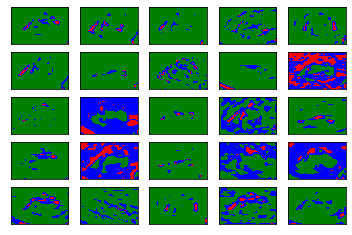

In [135]:
from matplotlib.colors import ListedColormap
from numpy import expand_dims
test_image = x_train[0]
# images_list = []
# images_list.append(np.array(test_image))
# x = np.asarray(images_list)
x = expand_dims(test_image, axis=0)
x = imagenet_utils.preprocess_input(x, mode='tf')
feature_maps = SE_cnn_model.predict(x)
#feature_maps.shape
cMap = ListedColormap(['green', 'blue','red'])
square = 5
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap=cMap, aspect='auto')
        ix += 1
# show the figure
pyplot.show()

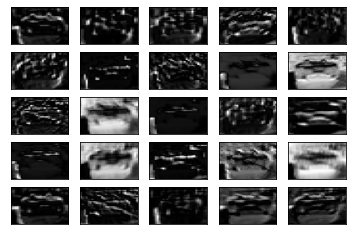

In [120]:
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray', aspect='auto')
        ix += 1
# show the figure
pyplot.show()

REFER THE RESIDUAL ATTENTION NETWORK IPYNB FILE FOR THE SIMILAR ANALYSIS ON RESIDUAL ATTENTION NETWORK MODEL

## CONCLUSION:
From this comparative analysis, I have noticed how both the Attention and Squeeze and Excitation techniques help improve the accuracy of image classification. With the Attention tecnique, the features that are specific to that class which the image is classified as are highlighted, where as with the Squeeze and Excitation technique informative features are created by fusing both channel-wise and spatial information within local receptive fields. Seeing the effects of these tecniques in live has helped me get a clear understanding of them.